In [1]:
# append parent to path to allow imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent)) 

In [ ]:


from pathlib import Path
import cv2
import numpy as np

from src.face import FaceDetector
from src.mask import MaskHandler
from src.projectUtils import Utils

In [ ]:
fd = FaceDetector()
mh = MaskHandler()

IMAGE_PATH = Path('test_images/helen1.jpg')

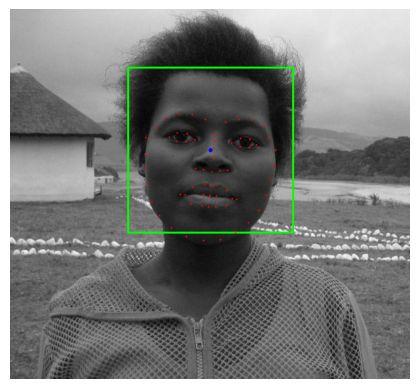

In [ ]:
img_rgb, _, _, landmarks_all_faces = fd.detect(IMAGE_PATH)
Utils.display(img_rgb)

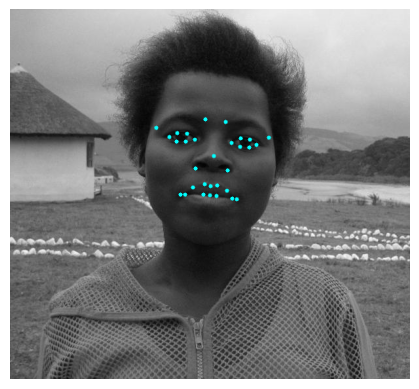

1


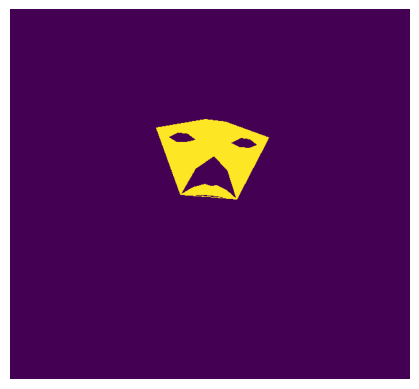

In [ ]:
masked_img, selected_pts = mh.get_mask_points(IMAGE_PATH, landmarks_all_faces)
Utils.display(masked_img)

masks, masked_imgs = mh.build_masks(IMAGE_PATH, selected_pts)
print(len(masks))
Utils.display(masks[0])

1


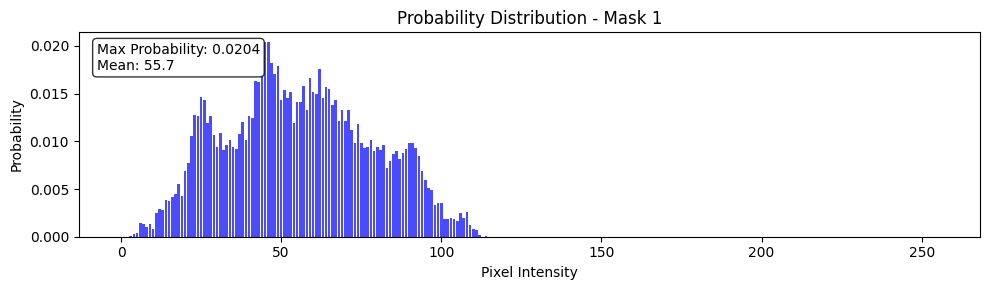

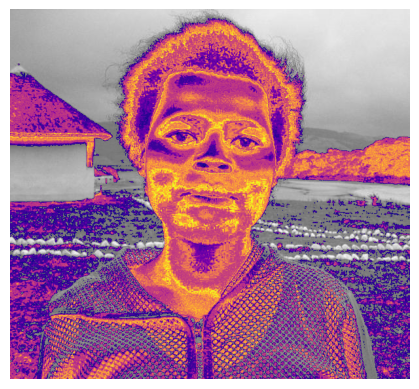

In [ ]:
intensity_histograms = mh.get_intensity_histograms(IMAGE_PATH, masks)

print(len(intensity_histograms))
Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

1
1
1


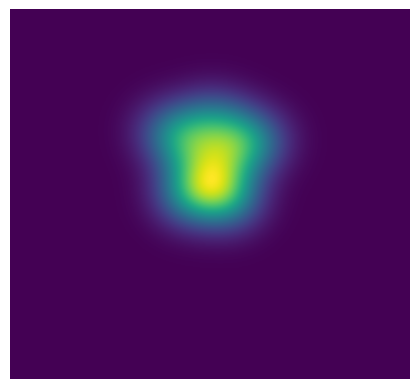

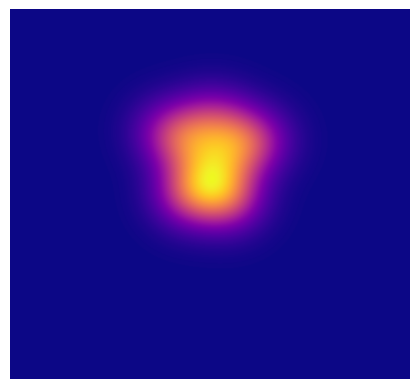

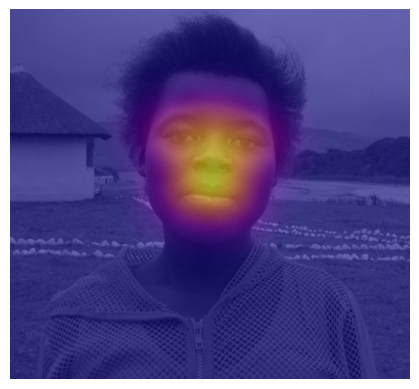

In [ ]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(IMAGE_PATH, selected_pts)

print(len(prior_face_masks))
print(len(heatmaps))
print(len(heatmaps_blended))

idx = 0

Utils.display(prior_face_masks[idx])
Utils.display(heatmaps[idx])
Utils.display(heatmaps_blended[idx])

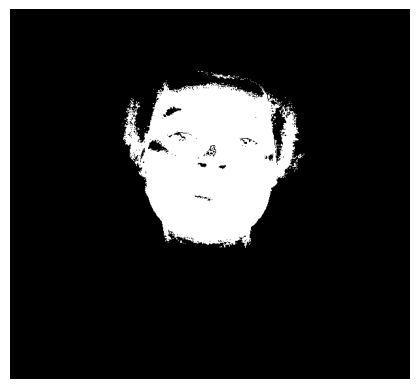

In [ ]:
alpha = 0.69
lambda_ = 0.0018

skin_pixel_maps = mh.get_skin_pixel_maps(IMAGE_PATH, intensity_histograms, prior_face_masks, alpha, lambda_)

for i in skin_pixel_maps:
    Utils.display(i, cmap="gray")